# Automatic rendering of NumPyro models

In this tutorial we will demonstrate how to create beautiful visualizations of your probabilistic graphical models using [ `numpyro.render_model()` ](https://num.pyro.ai/en/stable/utilities.html#render-model).

In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [1]:
import flax
import flax.linen as flax_nn
from numpyro.contrib.module import flax_module
import numpy as np
from jax import nn
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import numpyro.distributions.constraints as constraints

assert numpyro.__version__.startswith("0.9.2")

## A Simple Example

The visualization interface can be readily used with your models:

In [2]:
def model(data):
    m = numpyro.sample("m", dist.Normal(0, 1))
    sd = numpyro.sample("sd", dist.LogNormal(m, 1))
    with numpyro.plate("N", len(data)):
        numpyro.sample("obs", dist.Normal(m, sd), obs=data)

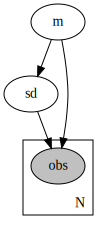

In [3]:
data = jnp.ones(10)
numpyro.render_model(model, model_args=(data,))

The visualization can be saved to a file by providing `filename='path'` to `numpyro.render_model`. You can use different formats such as PDF or PNG by changing the filename's suffix.
When not saving to a file (`filename=None`), you can also change the format with `graph.format = 'pdf'` where `graph` is the object returned by `numpyro.render_model`.

In [4]:
graph = numpyro.render_model(model, model_args=(data,), filename="model.pdf")

## Tweaking the visualization

As `numpyro.render_model` returns an object of type `graphviz.dot.Digraph`, you can further improve the visualization of this graph.
For example, you could use the [unflatten preprocessor](https://graphviz.readthedocs.io/en/stable/api.html#graphviz.unflatten) to improve the layout aspect ratio for more complex models.

In [5]:
def mace(positions, annotations):
    """
    This model corresponds to the plate diagram in Figure 3 of https://www.aclweb.org/anthology/Q18-1040.pdf.
    """
    num_annotators = int(np.max(positions)) + 1
    num_classes = int(np.max(annotations)) + 1
    num_items, num_positions = annotations.shape

    with numpyro.plate("annotator", num_annotators):
        epsilon = numpyro.sample("epsilon", dist.Dirichlet(jnp.full(num_classes, 10)))
        theta = numpyro.sample("theta", dist.Beta(0.5, 0.5))

    with numpyro.plate("item", num_items, dim=-2):
        c = numpyro.sample("c", dist.DiscreteUniform(0, num_classes - 1))

        with numpyro.plate("position", num_positions):
            s = numpyro.sample("s", dist.Bernoulli(1 - theta[positions]))
            probs = jnp.where(
                s[..., None] == 0, nn.one_hot(c, num_classes), epsilon[positions]
            )
            numpyro.sample("y", dist.Categorical(probs), obs=annotations)


positions = np.array([1, 1, 1, 2, 3, 4, 5])
# fmt: off
annotations = np.array([
    [1, 3, 1, 2, 2, 2, 1, 3, 2, 2, 4, 2, 1, 2, 1,
     1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1,
     1, 3, 1, 2, 2, 4, 2, 2, 3, 1, 1, 1, 2, 1, 2],
    [1, 3, 1, 2, 2, 2, 2, 3, 2, 3, 4, 2, 1, 2, 2,
     1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 1, 1,
     1, 3, 1, 2, 2, 3, 2, 3, 3, 1, 1, 2, 3, 2, 2],
    [1, 3, 2, 2, 2, 2, 2, 3, 2, 2, 4, 2, 1, 2, 1,
     1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2,
     1, 3, 1, 2, 2, 3, 1, 2, 3, 1, 1, 1, 2, 1, 2],
    [1, 4, 2, 3, 3, 3, 2, 3, 2, 2, 4, 3, 1, 3, 1,
     2, 1, 1, 2, 1, 2, 2, 3, 2, 1, 1, 2, 1, 1, 1,
     1, 3, 1, 2, 3, 4, 2, 3, 3, 1, 1, 2, 2, 1, 2],
    [1, 3, 1, 1, 2, 3, 1, 4, 2, 2, 4, 3, 1, 2, 1,
     1, 1, 1, 2, 3, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1,
     1, 2, 1, 2, 2, 3, 2, 2, 4, 1, 1, 1, 2, 1, 2],
    [1, 3, 2, 2, 2, 2, 1, 3, 2, 2, 4, 4, 1, 1, 1,
     1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2,
     1, 3, 1, 2, 3, 4, 3, 3, 3, 1, 1, 1, 2, 1, 2],
    [1, 4, 2, 1, 2, 2, 1, 3, 3, 3, 4, 3, 1, 2, 1,
     1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1,
     1, 3, 1, 2, 2, 3, 2, 3, 2, 1, 1, 1, 2, 1, 2],
]).T
# fmt: on

# we subtract 1 because the first index starts with 0 in Python
positions -= 1
annotations -= 1

mace_graph = numpyro.render_model(mace, model_args=(positions, annotations))

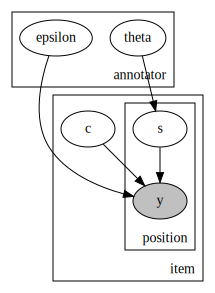

In [6]:
# default layout
mace_graph

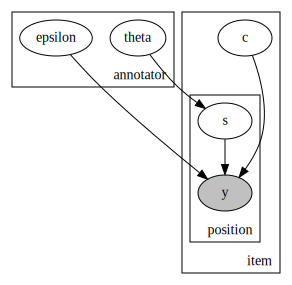

In [7]:
# layout after processing the layout with unflatten
mace_graph.unflatten(stagger=2)

## Rendering the parameters

We can render the parameters defined as `numpyro.param` by setting `render_params=True` in `numpyro.render_model`. 

In [8]:
def model(data):
    m = numpyro.param("m", 0.0)
    sd = numpyro.param("sd", 1.0, constraint=constraints.positive)
    lambd = numpyro.sample("lambda", dist.LogNormal(m, sd))
    with numpyro.plate("N", len(data)):
        numpyro.sample("obs", dist.Exponential(lambd), obs=data)

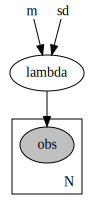

In [9]:
data = jnp.ones(10)
numpyro.render_model(model, model_args=(data,), render_params=True)

## Distribution and Constraint annotations

It is possible to display the distribution of each RV in the generated plot by providing `render_distributions=True` when calling `pyro.render_model`. The constraints associated with parameters are also displayed when `render_distributions=True`.

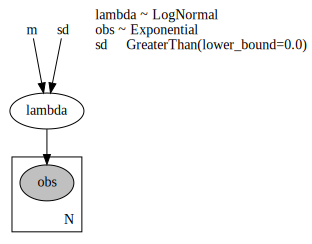

In [10]:
numpyro.render_model(
    model, model_args=(data,), render_params=True, render_distributions=True
)

In the above plot **'~'** denotes the distribution of RV and **'$\in$'** denotes the constraint of parameter.

## Rendering neural network's parameters

In [11]:
def model(data):
    lambda_base = numpyro.sample("lambda", dist.Normal(0, 1))
    net = flax_module("affine_net", flax_nn.Dense(1), input_shape=(1,))
    lambd = jnp.exp(net(jnp.expand_dims(lambda_base, -1)).squeeze(-1))
    with numpyro.plate("N", len(data)):
        numpyro.sample("obs", dist.Exponential(lambd), obs=data)

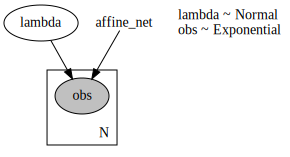

In [12]:
numpyro.render_model(
    model, model_args=(data,), render_distributions=True, render_params=True
)

## Overlapping non-nested plates

Note that overlapping non-nested plates may be drawn as multiple rectangles.

In [13]:
def model():
    plate1 = numpyro.plate("plate1", 2, dim=-2)
    plate2 = numpyro.plate("plate2", 3, dim=-1)
    with plate1:
        x = numpyro.sample("x", dist.Normal(0, 1))
    with plate1, plate2:
        y = numpyro.sample("y", dist.Normal(x, 1))
    with plate2:
        numpyro.sample("z", dist.Normal(y.sum(-2, keepdims=True), 1), obs=jnp.zeros(3))

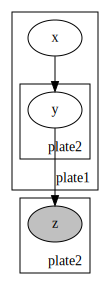

In [14]:
numpyro.render_model(model)